In [1]:
import pandas as pd
import numpy as np
from scipy import interp
#import matplotlib.pyplot as plt
import os

from IPython.display import Image
import pydotplus
import graphviz
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression,Ridge
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV,train_test_split,cross_val_score,cross_validate
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, roc_auc_score,roc_curve, auc, brier_score_loss
from sklearn import tree
import xgboost as xgb
from xgboost import XGBClassifier
from itertools import cycle

import keras
import tensorflow as tf
import tensorflow_probability as tfp
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, Embedding
from tensorflow.keras import backend as K

import lightgbm


Bad key savefig.frameon in file C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
Y

In [2]:
from sklearn.metrics import roc_auc_score
def y_roc(estimator,X):
    y_scores=[]
    for list in estimator.predict_proba(X):
        y_scores.append(list[1])
    return y_scores
def y_roc_regression(estimator,X):
    y_scores=[]
    for list in estimator.predict(X):
        y_scores.append(list)
    return y_scores
def cv_roc_plot(estimator,X,y):
    cv = StratifiedKFold(n_splits=4,shuffle=False)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    for train,test in cv.split(X,y):
        prediction = estimator.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
        fpr, tpr, t = roc_curve(y.iloc[test], prediction[:, 1])
        tpr[0]=0
        tpr[-1]=1
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    return mean_fpr, mean_tpr, mean_auc
def brier_score(y_prob_raw,y_true):
    y_prob=[prob[1] for prob in y_prob_raw]
    if len(y_prob)!=len(y_true):
        print('Error: two lists must have same length')
        return
    out = 0
    for prob_1,y in zip(y_prob,y_true):
        out+=(prob_1-y)**2
    return out/len(y_prob)
def get_prob_1(y_prob_raw):
    return [prob[1] for prob in y_prob_raw]
def aver_prob(prob_lists):
    n=len(prob_lists)
    return np.sum(np.array(prob_lists),0)/n

### Feature engineering
Including filling missing value, scaling and encoding predictors

In [3]:
# Discard unavailable features
raw_train=pd.read_csv(r'.\data\NIJ_s_Recidivism_Challenge_Training_Dataset.csv')
raw_train=raw_train.drop(columns=['Violations_ElectronicMonitoring',
       'Violations_Instruction', 'Violations_FailToReport',
       'Violations_MoveWithoutPermission', 'Delinquency_Reports',
       'Program_Attendances', 'Program_UnexcusedAbsences', 'Residence_Changes',
       'Avg_Days_per_DrugTest', 'DrugTests_THC_Positive',
       'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
       'DrugTests_Other_Positive', 'Percent_Days_Employed', 'Jobs_Per_Year',
       'Employment_Exempt'])
raw_train
raw_train.columns

Index(['ID', 'Gender', 'Race', 'Age_at_Release', 'Residence_PUMA',
       'Gang_Affiliated', 'Supervision_Risk_Score_First',
       'Supervision_Level_First', 'Education_Level', 'Dependents',
       'Prison_Offense', 'Prison_Years', 'Prior_Arrest_Episodes_Felony',
       'Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent',
       'Prior_Arrest_Episodes_Property', 'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probation', 'Condition_MH_SA', 'Condition_Cog_Ed',
     

In [4]:
# Change the dtype of the feature from object to intagar
raw_train['Residence_PUMA']=raw_train['Residence_PUMA'].astype('category')
raw_train['Residence_PUMA']=raw_train['Residence_PUMA'].cat.codes
raw_train['Age_at_Release']=raw_train['Age_at_Release'].apply(lambda x: int(x[:2]))
raw_train['Dependents']=raw_train['Dependents'].apply(lambda x: int(x[:1]))
raw_train['Prior_Arrest_Episodes_Felony']=raw_train['Prior_Arrest_Episodes_Felony'].apply(lambda x: int(x[:2]))
raw_train['Prior_Arrest_Episodes_Drug']=raw_train['Prior_Arrest_Episodes_Drug'].apply(lambda x: int(x[:2]))
raw_train['Prior_Arrest_Episodes_Misd']=raw_train['Prior_Arrest_Episodes_Misd'].apply(lambda x: int(x[:2]))
raw_train['Prior_Arrest_Episodes_Violent']=raw_train['Prior_Arrest_Episodes_Violent'].apply(lambda x: int(x[:2]))
raw_train['Prior_Arrest_Episodes_Property']=raw_train['Prior_Arrest_Episodes_Property'].apply(lambda x: int(x[:2]))
raw_train['Prior_Arrest_Episodes_PPViolationCharges']=raw_train['Prior_Arrest_Episodes_PPViolationCharges'].apply(lambda x: int(x[:2]))
raw_train['Prior_Conviction_Episodes_Felony']=raw_train['Prior_Conviction_Episodes_Felony'].apply(lambda x: int(x[:1]))
raw_train['Prior_Conviction_Episodes_Misd']=raw_train['Prior_Conviction_Episodes_Misd'].apply(lambda x: int(x[:1]))
raw_train['Prior_Conviction_Episodes_Prop']=raw_train['Prior_Conviction_Episodes_Prop'].apply(lambda x: int(x[:1]))
raw_train['Prior_Conviction_Episodes_Drug']=raw_train['Prior_Conviction_Episodes_Drug'].apply(lambda x: int(x[:1]))
#raw_train['Delinquency_Reports']=raw_train['Delinquency_Reports'].apply(lambda x: int(x[:1]))
#raw_train['Program_Attendances']=raw_train['Program_Attendances'].apply(lambda x: int(x[:2]))
#raw_train['Program_UnexcusedAbsences']=raw_train['Program_UnexcusedAbsences'].apply(lambda x: int(x[:1]))
#raw_train['Residence_Changes']=raw_train['Residence_Changes'].apply(lambda x: int(x[:1]))


# scale the columns which are not bool or category
      
scaler = StandardScaler()
scaling_set=[]
for column in raw_train.columns:
    if raw_train[column].dtype == object:
        raw_train[column]=raw_train[column].astype('category')
        raw_train[column]=raw_train[column].cat.codes
    elif raw_train[column].dtype in ['int64','float32','float64'] :
        scaling_set+=[column]
raw_train[scaling_set]=scaler.fit_transform(raw_train[scaling_set].values)

In [8]:
# remove outliers, missing values of 'Supervision_Risk_Score_First' and intersection of 'Supervision_Level_First' and 'Prison_Offense'
raw_train=raw_train.drop(index=raw_train[raw_train.Supervision_Risk_Score_First.isnull()].index)
raw_train=raw_train.drop(index=set(raw_train[raw_train.Supervision_Level_First.isnull()].index) & set(raw_train[raw_train.Prison_Offense .isnull()].index))
raw_train=raw_train.reset_index(drop=True)
# impute missing value 'Supervision_Level_First' and 'Prison_Offense' with relative feature
for missing_column in ['Supervision_Level_First','Prison_Offense']:
    test_index=raw_train[raw_train[missing_column]==-1].index
    train_index=raw_train[raw_train[missing_column]!=-1].index
    X=raw_train.drop(columns=[missing_column])
    y=raw_train[missing_column]
    logreg = LogisticRegression()
    logreg.fit(X.iloc[train_index,:],y[train_index])
    raw_train.loc[test_index,missing_column]=logreg.predict(X.iloc[test_index,:])
    raw_train[missing_column]=raw_train[missing_column].astype('category')
    raw_train[missing_column]=raw_train[missing_column].cat.codes

C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

Logistic regression train score: 0.7164853792908603 
 test score: 0.7096045197740113 
 Logistic regression train Brier score: 0.18688724440002552 
 test Brier score: 0.1912073443404502 
 AUROC: 0.6965366554518414
Random forest train score: 1.0 
 test score: 0.7081920903954803 
 Random forest  train Brier score: 0.02633926009637379 
 test Brier score: 0.195459635907094 
 AUROC: 0.6752396761039465
SGD best layer size: {'min_samples_split': 4, 'n_estimators': 100} 
 best train score: -0.18693236132593608 
 test score: -0.1907786576195972 
 SGD  train Brier score: 0.1783118708881963 
 test Brier score: 0.19077865761959653 
 AUROC: 0.6973354820393405
Epoch 1/200


C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


310/310 [==============================] - 1s 2ms/step - loss: 0.7273 - accuracy: 0.6220 - val_loss: 0.5805 - val_accuracy: 0.7032
Epoch 2/200
310/310 [==============================] - 0s 1ms/step - loss: 0.6061 - accuracy: 0.6893 - val_loss: 0.5755 - val_accuracy: 0.7043
Epoch 3/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5914 - accuracy: 0.7012 - val_loss: 0.5741 - val_accuracy: 0.7022
Epoch 4/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5843 - accuracy: 0.7027 - val_loss: 0.5728 - val_accuracy: 0.7060
Epoch 5/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5811 - accuracy: 0.7035 - val_loss: 0.5702 - val_accuracy: 0.7060
Epoch 6/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5812 - accuracy: 0.7018 - val_loss: 0.5706 - val_accuracy: 0.7034
Epoch 7/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5777 - accuracy: 0.7071 - val_loss: 0.5694 - val_accuracy: 0.7039
Epoch 8/200

310/310 [==============================] - 0s 1ms/step - loss: 0.5615 - accuracy: 0.7125 - val_loss: 0.5585 - val_accuracy: 0.7116
Epoch 59/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5604 - accuracy: 0.7118 - val_loss: 0.5589 - val_accuracy: 0.7105
Epoch 60/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5611 - accuracy: 0.7150 - val_loss: 0.5576 - val_accuracy: 0.7095
Epoch 61/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5619 - accuracy: 0.7094 - val_loss: 0.5571 - val_accuracy: 0.7133
Epoch 62/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5599 - accuracy: 0.7133 - val_loss: 0.5564 - val_accuracy: 0.7121
Epoch 63/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5638 - accuracy: 0.7065 - val_loss: 0.5576 - val_accuracy: 0.7121
Epoch 64/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5609 - accuracy: 0.7108 - val_loss: 0.5566 - val_accuracy: 0.7119
Epoch

Epoch 115/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5596 - accuracy: 0.7087 - val_loss: 0.5573 - val_accuracy: 0.7112
Epoch 116/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5586 - accuracy: 0.7113 - val_loss: 0.5560 - val_accuracy: 0.7126
Epoch 117/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5566 - accuracy: 0.7148 - val_loss: 0.5558 - val_accuracy: 0.7105
Epoch 118/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5585 - accuracy: 0.7107 - val_loss: 0.5558 - val_accuracy: 0.7130
Epoch 119/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5587 - accuracy: 0.7151 - val_loss: 0.5556 - val_accuracy: 0.7119
Epoch 120/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5570 - accuracy: 0.7137 - val_loss: 0.5558 - val_accuracy: 0.7102
Epoch 121/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5600 - accuracy: 0.7124 - val_loss: 0.5563 - val_ac

310/310 [==============================] - 0s 1ms/step - loss: 0.5562 - accuracy: 0.7149 - val_loss: 0.5563 - val_accuracy: 0.7123
Epoch 172/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5592 - accuracy: 0.7121 - val_loss: 0.5558 - val_accuracy: 0.7114
Epoch 173/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5566 - accuracy: 0.7117 - val_loss: 0.5551 - val_accuracy: 0.7116
Epoch 174/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5587 - accuracy: 0.7106 - val_loss: 0.5549 - val_accuracy: 0.7114
Epoch 175/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5558 - accuracy: 0.7144 - val_loss: 0.5551 - val_accuracy: 0.7107
Epoch 176/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5567 - accuracy: 0.7138 - val_loss: 0.5551 - val_accuracy: 0.7105
Epoch 177/200
310/310 [==============================] - 0s 1ms/step - loss: 0.5567 - accuracy: 0.7110 - val_loss: 0.5582 - val_accuracy: 0.7105

C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:4

MLP train Brier score: 0.1853538088776672 
 test Brier score: 0.19115163396646015 
 AUROC: 0.6959410983528046
Xgboost best layer size: {'max_depth': 10, 'n_estimators': 100, 'reg_alpha': 0.001, 'reg_lambda': 1000} 
 best train score: -0.18703118876632155 
 test score: -0.19157262020243898 
 Xgboost train Brier score: 0.16919120187206355 
 test Brier score: 0.19157262008481185 
 AUROC: 0.6937692651282942


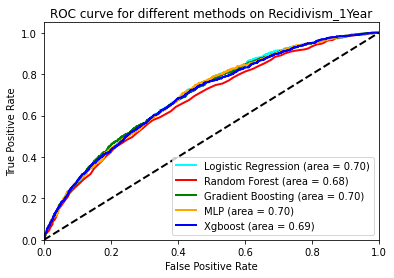

In [9]:
from sklearn.linear_model import LinearRegression,LogisticRegression


X_train1,X_test1,y_train1,y_test1=train_test_split(raw_train.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_train['Recidivism_Arrest_Year1'],test_size=0.2)
fpr_list,tpr_list,auc_list=dict(),dict(),dict()


logistic=LogisticRegression(max_iter=1000)
logistic.fit(X_train1.fillna(0),y_train1)
fpr_list[0], tpr_list[0], _ = roc_curve(y_test1, y_roc(logistic,X_test1.fillna(0)))
print('Logistic regression train score:',
      logistic.score(X_train1.fillna(0),y_train1),'\n test score:',logistic.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Logistic regression train Brier score:',
      brier_score(logistic.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(logistic.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(logistic,X_test1.fillna(0))))

RF=RandomForestClassifier(n_estimators=150,min_samples_split=2)
RF.fit(X_train1.fillna(0),y_train1)
fpr_list[1], tpr_list[1], _ = roc_curve(y_test1, y_roc(RF,X_test1.fillna(0)))
print('Random forest train score:',
      RF.score(X_train1.fillna(0),y_train1),'\n test score:',RF.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Random forest  train Brier score:',
      brier_score(RF.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(RF.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(RF,X_test1.fillna(0))))

GBDT=GradientBoostingClassifier()
params_SGD={'n_estimators':[150,100,50],'min_samples_split':[2,4]}
grid_SGD=GridSearchCV(GBDT, scoring='neg_brier_score',param_grid=params_SGD,cv=3)
grid_SGD.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[2], tpr_list[2], _ = roc_curve(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0)))
print('SGD best layer size:',grid_SGD.best_params_,'\n best train score:',
      grid_SGD.best_score_,'\n test score:',grid_SGD.score(X_test1.fillna(0),y_test1.fillna(0)),'\n SGD  train Brier score:',
      brier_score(grid_SGD.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_SGD.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0))))

pipe = Sequential()
n_cols = X_train1.shape[1]
pipe.add(BatchNormalization(input_shape=(n_cols,)))
pipe.add(Dense(70, activation= 'linear'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(100, activation='linear'))
pipe.add(BatchNormalization())
pipe.add(Dense(2, activation='softmax'))
    #model.compile(
        #optimizer='Adam',
        #loss='mean_squared_error',
        #metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=50)
sgd = keras.optimizers.SGD(lr=.001, decay=2e-4, momentum=0.9, nesterov=True)
pipe.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'sgd', metrics=['accuracy'])
history=pipe.fit(X_train1.fillna(0).astype('float32'), y_train1, validation_split=0.3, epochs=200, callbacks=[early_stopping_monitor])
#history=model.fit(X_train, y_train, validation_split=0.2, epochs=25)
score = pipe.evaluate(X_test1.fillna(0).astype('float32'), y_test1, verbose=0)
pipe.fit(X_train1.fillna(0).astype('float32'),y_train1.fillna(0))
fpr_list[3], tpr_list[3], _ = roc_curve(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32')))
print('MLP train Brier score:',
      brier_score(pipe.predict_proba(X_train1.fillna(0).astype('float32')),y_train1),'\n test Brier score:',brier_score(pipe.predict_proba(X_test1.fillna(0).astype('float32')),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32'))))


XGB=XGBClassifier(objective='binary:logistic')
params_XGB={'n_estimators':[100,50],'max_depth':[8,10],'reg_alpha':[0.001],'reg_lambda':[1000]}
grid_XGB=GridSearchCV(XGB, scoring='neg_brier_score',param_grid=params_XGB,cv=3)
grid_XGB.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[4], tpr_list[4], _ = roc_curve(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0)))
print('Xgboost best layer size:',grid_XGB.best_params_,'\n best train score:',
      grid_XGB.best_score_,'\n test score:',grid_XGB.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Xgboost train Brier score:',
      brier_score(grid_XGB.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_XGB.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0))))



colors = cycle(['aqua', 'red', 'green','orange','blue'])
labels=['Logistic Regression','Random Forest','Gradient Boosting','MLP','Xgboost']
for i, label, color in zip(range(len(fpr_list)), labels, colors):
    legend= label + ' (area = {1:0.2f})'''.format(i, auc(fpr_list[i], tpr_list[i]))
    plt.plot(fpr_list[i], tpr_list[i], color=color, lw=2,label=legend)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for different methods on Recidivism_1Year')
plt.legend(loc="lower right")
plt.savefig('ROC_plot.png',dpi=300)
plt.show()

### Feature importance
As required by the task

In [10]:
GBDT_importance=pd.DataFrame()
GBDT_importance['Feature']=raw_train.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1).columns
GBDT_importance['importance']=grid_SGD.best_estimator_.feature_importances_
GBDT_importance=GBDT_importance.sort_values(by='importance',ascending=False)
GBDT_importance


,Feature,importance
2,Age_at_Release,0.212413
4,Gang_Affiliated,0.139099
16,Prior_Arrest_Episodes_PPViolationCharges,0.134133
14,Prior_Arrest_Episodes_Property,0.105199
11,Prior_Arrest_Episodes_Felony,0.097512
10,Prison_Years,0.036586
3,Residence_PUMA,0.034104
12,Prior_Arrest_Episodes_Misd,0.033652
9,Prison_Offense,0.029626
20,Prior_Conviction_Episodes_Misd,0.019174


In [30]:
xgb_fea_imp=pd.DataFrame(list(grid_XGB.best_estimator_.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)
xgb_fea_imp.to_csv('xgb_fea_imp.csv')

from xgboost import plot_importance
plot_importance(grid_XGB.best_estimator_, )

                                               feature  importance
4                                      Residence_PUMA        1696
11                       Supervision_Risk_Score_First        1089
3                        Prior_Arrest_Episodes_Felony         791
10                                     Age_at_Release         748
13                                     Prison_Offense         654
20                         Prior_Arrest_Episodes_Drug         632
7                          Prior_Arrest_Episodes_Misd         616
17           Prior_Arrest_Episodes_PPViolationCharges         574
5                                        Prison_Years         492
1                      Prior_Arrest_Episodes_Property         476
18                     Prior_Conviction_Episodes_Misd         475
25                      Prior_Arrest_Episodes_Violent         462
6                                          Dependents         449
15                                    Education_Level         400
14       

ImportError: You must install matplotlib to plot importance

### Brier as loss function

In [56]:

def custom_asymmetric_train(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*10.0*residual, -2*residual)
    hess = np.where(residual<0, 2*10.0, 2.0)
    return grad, hess

def custom_asymmetric_valid(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual**2)*10.0, residual**2) 
    return "custom_asymmetric_eval", np.mean(loss), False

In [64]:
gbm.predict(X_test1)

AttributeError: 'LGBMRegressor' object has no attribute 'predict_prob'

In [59]:
import lightgbm

# default lightgbm model with sklearn api
gbm = lightgbm.LGBMRegressor() 

# updating objective function to custom
# default is "regression"
# also adding metrics to check different scores
gbm.set_params(**{'objective': custom_asymmetric_train}, metrics = ["mse", 'mae'])

# fitting model 
gbm.fit(
    X_train1,
    y_train1,
    eval_set=[(X_test1, y_test1)],
    eval_metric=custom_asymmetric_valid,
    verbose=False,
)

y_pred = gbm.predict(X_test1)


# create dataset for lightgbm
# if you want to re-use data, remember to set free_raw_data=False
'''lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, free_raw_data=False)

# specify your configurations as a dict
params = {
    'objective': 'regression',
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model=gbm,
                fobj=custom_asymmetric_train,
                feval=custom_asymmetric_valid,
                valid_sets=lgb_eval)
                
y_pred = gbm.predict(X_valid)'''

"lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)\nlgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, free_raw_data=False)\n\n# specify your configurations as a dict\nparams = {\n    'objective': 'regression',\n    'verbose': 0\n}\n\ngbm = lgb.train(params,\n                lgb_train,\n                num_boost_round=10,\n                init_model=gbm,\n                fobj=custom_asymmetric_train,\n                feval=custom_asymmetric_valid,\n                valid_sets=lgb_eval)\n                \ny_pred = gbm.predict(X_valid)"

In [61]:
len(y_pred)

4507

### PUMA external data

In [3]:
data_PUMA=pd.read_csv(r'.\data\ss13hga_13.csv')
pdata_PUMA=pd.read_csv(r'.\data\ss13pga_13.csv')
data_PUMA['Code']=None
pdata_PUMA['Code']=None
data_PUMA['PUMA']=data_PUMA['PUMA'].astype(str)
pdata_PUMA['PUMA']=pdata_PUMA['PUMA'].astype(str)
PUMA_code_map={'1003':1,'4400':1,'1008':2,'4300':2,'1200':3, '1300':3,'1400':4,'1500':4,'1600':4,'1700':5,'1800':5,
              '2001':6,'2002':6,'2003':6,'4005':6,'100':7,'200':7,'500':7,'4000':8,'4100':8,'4200':8,'5001':9,'6001':9,'6002':9,
              '2400':10,'5002':10,'1001':11,'3004':11,'4600':11,'1002':12, '1005':12, '3300':12, '3400':12, '4001':12, '4002':12,
              '4006':12,'3101':13,'3102':13,'1900':14, '3900':14, '4003':14, '4004':14,'3001':15, '3002':15, '3003':15, '3005':15,
              '2500':16, '4500':16,'2800':17, '2900':17, '3200':17, '3500':17,'600':18, '700':18, '800':18,'900':19, '1100':19,
              '300':20, '401':20, '402':20, '1004':21, '2100':21 ,'2200':22, '2300':22, '1006':23, '1007':23, '2004':23,'2600':24, 
              '2700':24,'3600':25, '3700':25, '3800':25}
data_PUMA['Code']=data_PUMA['PUMA'].map(PUMA_code_map)
pdata_PUMA['Code']=pdata_PUMA['PUMA'].map(PUMA_code_map)
data_PUMA

,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,...,wgtp72,wgtp73,wgtp74,wgtp75,wgtp76,wgtp77,wgtp78,wgtp79,wgtp80,Code
0,H,127,5,1400,3,13,1000000,1007549,139,1,...,242,41,124,132,224,157,237,280,142,4
1,H,131,5,700,3,13,1000000,1007549,60,3,...,95,96,19,70,53,12,61,18,111,18
2,H,136,5,2200,3,13,1000000,1007549,22,1,...,7,23,33,40,38,19,33,19,8,22
3,H,151,5,1100,3,13,1000000,1007549,213,2,...,55,175,62,53,313,200,330,252,239,19
4,H,294,5,3400,3,13,1000000,1007549,64,2,...,59,19,61,109,102,99,74,73,97,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45693,H,1492766,5,5002,3,13,1000000,1007549,69,1,...,60,95,23,114,81,64,126,67,99,10
45694,H,1492793,5,100,3,13,1000000,1007549,53,2,...,132,51,60,106,39,77,57,49,79,7
45695,H,1492802,5,700,3,13,1000000,1007549,48,2,...,53,59,80,40,68,85,76,105,43,18
45696,H,1492814,5,2800,3,13,1000000,1007549,109,2,...,84,114,101,79,35,203,117,108,182,17


In [4]:
Law_enforcement=pd.read_excel(r'.\data\table_80_full_time_law_enforcement_employees_georgia_by_metropolitan_and_nonmetropolitan_counties_2012.xls')
crime_rates=pd.read_excel(r'.\data\georgia crime rates.xlsx',header=1)
crime_rates=crime_rates.groupby(by='County').sum().iloc[11:,:]
crime_len=pd.merge(Law_enforcement,crime_rates,left_on='County',right_on='County')
crime_len=crime_len.drop(columns=crime_len.columns[crime_len.isnull().any()])
crime_len

,County,Total law\nenforcement\nemployees,Total\nofficers,Total\ncivilians,Murder,Rape,Robbery,Assault,Burglary,Larceny,Vehicle Theft
0,Barrow,190,129,61,2,33,20,302,547,1551,145
1,Bartow,234,197,37,0,13,32,329,806,2263,264
2,Bibb,361,296,65,19,67,296,416,2500,6297,715
3,Brantley,43,19,24,0,1,7,16,191,243,10
4,Brooks,51,22,29,2,2,9,45,114,291,31
...,...,...,...,...,...,...,...,...,...,...,...
120,Webster,6,5,1,0,0,1,0,8,7,3
121,White,73,40,33,0,3,4,35,153,328,15
122,Wilcox,16,10,6,0,5,2,16,72,93,10
123,Wilkes,27,14,13,0,0,0,32,29,106,11


In [5]:
crime_len

,County,Total law\nenforcement\nemployees,Total\nofficers,Total\ncivilians,Murder,Rape,Robbery,Assault,Burglary,Larceny,Vehicle Theft
0,Barrow,190,129,61,2,33,20,302,547,1551,145
1,Bartow,234,197,37,0,13,32,329,806,2263,264
2,Bibb,361,296,65,19,67,296,416,2500,6297,715
3,Brantley,43,19,24,0,1,7,16,191,243,10
4,Brooks,51,22,29,2,2,9,45,114,291,31
...,...,...,...,...,...,...,...,...,...,...,...
120,Webster,6,5,1,0,0,1,0,8,7,3
121,White,73,40,33,0,3,4,35,153,328,15
122,Wilcox,16,10,6,0,5,2,16,72,93,10
123,Wilkes,27,14,13,0,0,0,32,29,106,11


In [6]:
crime_len=crime_len.set_index(keys='County')
crime_len['PUMA']=None
crime_len.loc['Barrow','PUMA']=3800
crime_len.loc['Bartow','PUMA']=2900
crime_len.loc['Bibb','PUMA']=1700
crime_len.loc['Bryan','PUMA']=200
crime_len.loc['Carroll','PUMA']=2300
crime_len.loc['Catoosa','PUMA']=2600
crime_len.loc['Chatham','PUMA']=401
crime_len.loc['Chattahoochee','PUMA']=1700
crime_len.loc['Cherokee','PUMA']=3101
crime_len.loc['Clarke','PUMA']=3600
crime_len.loc['Clayton','PUMA']=5001
crime_len.loc['Cobb','PUMA']=3001
crime_len.loc['Columbia','PUMA']=4100
crime_len.loc['Coweta','PUMA']=2100
crime_len.loc['Dade','PUMA']=2600
crime_len.loc['Dougherty','PUMA']=900
crime_len.loc['Effingham','PUMA']=300
crime_len.loc['Floyd','PUMA']=2500
crime_len.loc['Forsyth','PUMA']=3300
crime_len.loc['Fulton','PUMA']=4600
crime_len.loc['Glynn','PUMA']=100
crime_len.loc['Hall','PUMA']=3400
crime_len.loc['Haralson','PUMA']=2500
crime_len.loc['Heard','PUMA']=2200
crime_len.loc['Houston','PUMA']=1500
crime_len.loc['Long','PUMA']=200
crime_len.loc['Lowndes','PUMA']=600
crime_len.loc['McIntosh','PUMA']=100
crime_len.loc['Morgan','PUMA']=3900
crime_len.loc['Newton','PUMA']=4300
crime_len.loc['Paulding','PUMA']=4500
crime_len.loc['Pulaski','PUMA']=1500
crime_len.loc['Rockdale','PUMA']=4300
crime_len.loc['Walker','PUMA']=2600
crime_len.loc['Walton','PUMA']=3900
crime_len.loc['Whitfield','PUMA']=2700
crime_len.loc['Worth','PUMA']=800
crime_len.loc['Bulloch','PUMA']=300
crime_len.loc['Camden','PUMA']=100
crime_len.loc['Chattooga','PUMA']=2600
crime_len.loc['Decatur','PUMA']=2002
crime_len.loc['Dooly','PUMA']=2600
crime_len.loc['Jackson','PUMA']=3800
crime_len.loc['Macon','PUMA']=1400
crime_len.loc['Polk','PUMA']=2500
crime_len.loc['Screven','PUMA']=300
crime_len.loc['Thomas','PUMA']=800
crime_len.loc['Troup','PUMA']=2200
crime_len.loc['Union','PUMA']=1004
crime_len.drop(index=crime_len[crime_len.PUMA.isnull()].index,inplace=True)
crime_len['Code']=(crime_len['PUMA']).astype(str).map(PUMA_code_map)
crime_len=crime_len.astype(int)
crime_len=crime_len.groupby('Code').mean()
crime_len.reset_index(inplace=True)

In [7]:
PUMA_group=data_PUMA.groupby(by='Code',as_index=False).mean()
PUMA_group=PUMA_group.iloc[:,:-81].drop(columns=['SERIALNO', 'DIVISION', 'REGION', 'ST', 'ADJHSG', 'ADJINC',
       'WGTP'])
PUMA_group['TEN']=data_PUMA[['Code','TEN']].groupby(by='Code',as_index=False).agg(lambda x:x.value_counts().index[0])['TEN']
PUMA_new=pd.merge(PUMA_group,crime_len,left_on='Code',right_on='Code',how='outer')
PUMA_new=PUMA_new.fillna(PUMA_new.mean())

In [8]:
raw_train=pd.read_csv(r'.\data\NIJ_s_Recidivism_Challenge_Training_Dataset.csv')
raw_train=raw_train.drop(columns=['Violations_ElectronicMonitoring',
       'Violations_Instruction', 'Violations_FailToReport',
       'Violations_MoveWithoutPermission', 'Delinquency_Reports',
       'Program_Attendances', 'Program_UnexcusedAbsences', 'Residence_Changes',
       'Avg_Days_per_DrugTest', 'DrugTests_THC_Positive',
       'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
       'DrugTests_Other_Positive', 'Percent_Days_Employed', 'Jobs_Per_Year',
       'Employment_Exempt'])
raw_extend=pd.merge(raw_train,PUMA_new,left_on='Residence_PUMA',right_on='Code')

# Change the dtype of the feature from object to intagar
raw_extend['TEN']=raw_extend['TEN'].astype('category')
raw_extend['TEN']=raw_extend['TEN'].cat.codes
raw_extend['Residence_PUMA']=raw_extend['Residence_PUMA'].astype('category')
raw_extend['Residence_PUMA']=raw_extend['Residence_PUMA'].cat.codes
raw_extend['Age_at_Release']=raw_extend['Age_at_Release'].apply(lambda x: int(x[:2]))
raw_extend['Dependents']=raw_extend['Dependents'].apply(lambda x: int(x[:1]))
raw_extend['Prior_Arrest_Episodes_Felony']=raw_extend['Prior_Arrest_Episodes_Felony'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Arrest_Episodes_Drug']=raw_extend['Prior_Arrest_Episodes_Drug'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Arrest_Episodes_Misd']=raw_extend['Prior_Arrest_Episodes_Misd'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Arrest_Episodes_Violent']=raw_extend['Prior_Arrest_Episodes_Violent'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Arrest_Episodes_Property']=raw_extend['Prior_Arrest_Episodes_Property'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Arrest_Episodes_PPViolationCharges']=raw_extend['Prior_Arrest_Episodes_PPViolationCharges'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Conviction_Episodes_Felony']=raw_extend['Prior_Conviction_Episodes_Felony'].apply(lambda x: int(x[:1]))
raw_extend['Prior_Conviction_Episodes_Misd']=raw_extend['Prior_Conviction_Episodes_Misd'].apply(lambda x: int(x[:1]))
raw_extend['Prior_Conviction_Episodes_Prop']=raw_extend['Prior_Conviction_Episodes_Prop'].apply(lambda x: int(x[:1]))
raw_extend['Prior_Conviction_Episodes_Drug']=raw_extend['Prior_Conviction_Episodes_Drug'].apply(lambda x: int(x[:1]))
#raw_extend['Delinquency_Reports']=raw_extend['Delinquency_Reports'].apply(lambda x: int(x[:1]))
#raw_extend['Program_Attendances']=raw_extend['Program_Attendances'].apply(lambda x: int(x[:2]))
#raw_extend['Program_UnexcusedAbsences']=raw_extend['Program_UnexcusedAbsences'].apply(lambda x: int(x[:1]))
#raw_extend['Residence_Changes']=raw_extend['Residence_Changes'].apply(lambda x: int(x[:1]))

scaler = StandardScaler()
scaling_set=[]
for column in raw_extend.columns:
    if raw_extend[column].dtype == object:
        raw_extend[column]=raw_extend[column].astype('category')
        raw_extend[column]=raw_extend[column].cat.codes
    elif raw_extend[column].dtype in ['int64','float32','float64'] :
        scaling_set+=[column]
raw_extend[scaling_set]=scaler.fit_transform(raw_extend[scaling_set].values)

Logistic regression train score: 0.7175504770357222 
 test score: 0.7106722875526958 
 Logistic regression train Brier score: 0.18691464638118652 
 test Brier score: 0.18810059465232717 
 AUROC: 0.7005194805194805
Random forest train score: 1.0 
 test score: 0.7064566230308409 
 Random forest  train Brier score: 0.027115374438117824 
 test Brier score: 0.19288194660158314 
 AUROC: 0.676551578502798
SGD best layer size: {'min_samples_split': 2, 'n_estimators': 100} 
 best train score: -0.18858316159952715 
 test score: -0.18755638311823125 
 SGD  train Brier score: 0.1779068598468777 
 test Brier score: 0.18755638311823083 
 AUROC: 0.7048681941364869


C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
296/296 [==============================] - 1s 2ms/step - loss: 0.7612 - accuracy: 0.6052 - val_loss: 0.6051 - val_accuracy: 0.6993
Epoch 2/200
296/296 [==============================] - 0s 1ms/step - loss: 0.6404 - accuracy: 0.6769 - val_loss: 0.6051 - val_accuracy: 0.6993
Epoch 3/200
296/296 [==============================] - 0s 1ms/step - loss: 0.6106 - accuracy: 0.6953 - val_loss: 0.5992 - val_accuracy: 0.6993
Epoch 4/200
296/296 [==============================] - 0s 1ms/step - loss: 0.6080 - accuracy: 0.6954 - val_loss: 0.5987 - val_accuracy: 0.6993
Epoch 5/200
296/296 [==============================] - 0s 1ms/step - loss: 0.6019 - accuracy: 0.7019 - val_loss: 0.5955 - val_accuracy: 0.6993
Epoch 6/200
296/296 [==============================] - 0s 1ms/step - loss: 0.5981 - accuracy: 0.7012 - val_loss: 0.5932 - val_accuracy: 0.6993
Epoch 7/200
296/296 [==============================] - 0s 1ms/step - loss: 0.5934 - accuracy: 0.7022 - val_loss: 0.5890 - val_accuracy: 0.6993

Epoch 58/200
296/296 [==============================] - 0s 1ms/step - loss: 0.5631 - accuracy: 0.7074 - val_loss: 0.5650 - val_accuracy: 0.7133
Epoch 59/200
296/296 [==============================] - 0s 1ms/step - loss: 0.5595 - accuracy: 0.7100 - val_loss: 0.5637 - val_accuracy: 0.7138
Epoch 60/200
296/296 [==============================] - 0s 1ms/step - loss: 0.5627 - accuracy: 0.7061 - val_loss: 0.5633 - val_accuracy: 0.7173
Epoch 61/200
296/296 [==============================] - 0s 1ms/step - loss: 0.5619 - accuracy: 0.7100 - val_loss: 0.5628 - val_accuracy: 0.7143
Epoch 62/200
296/296 [==============================] - 0s 1ms/step - loss: 0.5605 - accuracy: 0.7092 - val_loss: 0.5632 - val_accuracy: 0.7148
Epoch 63/200
296/296 [==============================] - 0s 1ms/step - loss: 0.5634 - accuracy: 0.7084 - val_loss: 0.5632 - val_accuracy: 0.7165
Epoch 64/200
296/296 [==============================] - 0s 1ms/step - loss: 0.5620 - accuracy: 0.7091 - val_loss: 0.5644 - val_accuracy:

Epoch 115/200
296/296 [==============================] - 0s 1ms/step - loss: 0.5591 - accuracy: 0.7113 - val_loss: 0.5621 - val_accuracy: 0.7165
Epoch 116/200
296/296 [==============================] - 0s 1ms/step - loss: 0.5583 - accuracy: 0.7119 - val_loss: 0.5621 - val_accuracy: 0.7180
Epoch 117/200
296/296 [==============================] - 0s 1ms/step - loss: 0.5548 - accuracy: 0.7134 - val_loss: 0.5626 - val_accuracy: 0.7165
Epoch 118/200
296/296 [==============================] - 0s 1ms/step - loss: 0.5602 - accuracy: 0.7120 - val_loss: 0.5632 - val_accuracy: 0.7193
Epoch 119/200
296/296 [==============================] - 0s 1ms/step - loss: 0.5591 - accuracy: 0.7102 - val_loss: 0.5628 - val_accuracy: 0.7175
Epoch 120/200
296/296 [==============================] - 0s 1ms/step - loss: 0.5579 - accuracy: 0.7119 - val_loss: 0.5635 - val_accuracy: 0.7158
Epoch 121/200
423/423 [==============================] - 0s 1ms/step - loss: 0.5636 - accuracy: 0.7134


C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:4

MLP train Brier score: 0.1865408403094302 
 test Brier score: 0.18917124704734167 
 AUROC: 0.6985588756320464
Xgboost best layer size: {'colsample_bytree': 0.8, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'reg_lambda': 1000, 'subsample': 0.9} 
 best train score: -0.18811904238606814 
 test score: -0.1877925517419035 
 Xgboost train Brier score: 0.18134933853812088 
 test Brier score: 0.18779255174583864 
 AUROC: 0.7040091976677343


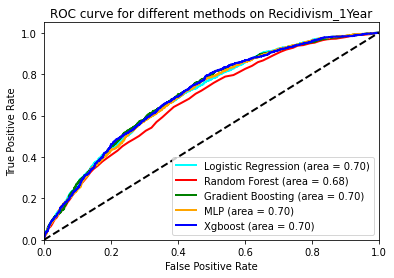

In [9]:
from sklearn.linear_model import LinearRegression,LogisticRegression


X_train1,X_test1,y_train1,y_test1=train_test_split(raw_extend.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_extend['Recidivism_Arrest_Year1'])
fpr_list,tpr_list,auc_list=dict(),dict(),dict()


logistic=LogisticRegression(max_iter=1000)
logistic.fit(X_train1.fillna(0),y_train1)
fpr_list[0], tpr_list[0], _ = roc_curve(y_test1, y_roc(logistic,X_test1.fillna(0)))
print('Logistic regression train score:',
      logistic.score(X_train1.fillna(0),y_train1),'\n test score:',logistic.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Logistic regression train Brier score:',
      brier_score(logistic.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(logistic.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(logistic,X_test1.fillna(0))))

RF=RandomForestClassifier(n_estimators=150,min_samples_split=2)
RF.fit(X_train1.fillna(0),y_train1)
fpr_list[1], tpr_list[1], _ = roc_curve(y_test1, y_roc(RF,X_test1.fillna(0)))
print('Random forest train score:',
      RF.score(X_train1.fillna(0),y_train1),'\n test score:',RF.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Random forest  train Brier score:',
      brier_score(RF.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(RF.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(RF,X_test1.fillna(0))))

GBDT=GradientBoostingClassifier()
params_SGD={'n_estimators':[150,100],'min_samples_split':[2,4]}
grid_SGD=GridSearchCV(GBDT,param_grid=params_SGD, scoring='neg_brier_score',cv=3)
grid_SGD.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[2], tpr_list[2], _ = roc_curve(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0)))
print('SGD best layer size:',grid_SGD.best_params_,'\n best train score:',
      grid_SGD.best_score_,'\n test score:',grid_SGD.score(X_test1.fillna(0),y_test1.fillna(0)),'\n SGD  train Brier score:',
      brier_score(grid_SGD.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_SGD.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0))))

pipe = Sequential()
n_cols = X_train1.shape[1]
pipe.add(BatchNormalization(input_shape=(n_cols,)))
pipe.add(Dense(70, activation= 'linear'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(100, activation='linear'))
pipe.add(BatchNormalization())
pipe.add(Dense(2, activation='softmax'))
    #model.compile(
        #optimizer='Adam',
        #loss='mean_squared_error',
        #metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=50)
sgd = keras.optimizers.SGD(lr=.001, decay=2e-4, momentum=0.9, nesterov=True)
pipe.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'sgd', metrics=['accuracy'])
history=pipe.fit(X_train1.fillna(0).astype('float32'), y_train1, validation_split=0.3, epochs=200, callbacks=[early_stopping_monitor])
#history=model.fit(X_train, y_train, validation_split=0.2, epochs=25)
score = pipe.evaluate(X_test1.fillna(0).astype('float32'), y_test1, verbose=0)
pipe.fit(X_train1.fillna(0).astype('float32'),y_train1.fillna(0))
fpr_list[3], tpr_list[3], _ = roc_curve(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32')))
print('MLP train Brier score:',
      brier_score(pipe.predict_proba(X_train1.fillna(0).astype('float32')),y_train1),'\n test Brier score:',brier_score(pipe.predict_proba(X_test1.fillna(0).astype('float32')),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32'))))


XGB=XGBClassifier()
params_XGB={    'n_estimators': [50, 100],
    'max_depth': [2, 3],
    'min_child_weight': [2,4,6],
    'subsample': [0.9],
    'colsample_bytree': [0.8],'reg_lambda':[1000]}
grid_XGB=GridSearchCV(XGB,param_grid=params_XGB, scoring='neg_brier_score',cv=3)
grid_XGB.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[4], tpr_list[4], _ = roc_curve(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0)))
print('Xgboost best layer size:',grid_XGB.best_params_,'\n best train score:',
      grid_XGB.best_score_,'\n test score:',grid_XGB.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Xgboost train Brier score:',
      brier_score(grid_XGB.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_XGB.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0))))



colors = cycle(['aqua', 'red', 'green','orange','blue'])
labels=['Logistic Regression','Random Forest','Gradient Boosting','MLP','Xgboost']
for i, label, color in zip(range(len(fpr_list)), labels, colors):
    legend= label + ' (area = {1:0.2f})'''.format(i, auc(fpr_list[i], tpr_list[i]))
    plt.plot(fpr_list[i], tpr_list[i], color=color, lw=2,label=legend)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for different methods on Recidivism_1Year')
plt.legend(loc="lower right")
plt.savefig('ROC_plot.png',dpi=300)
plt.show()

In [ ]:
GBDT_importance=pd.DataFrame()
GBDT_importance['Feature']=raw_extend.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1).columns
GBDT_importance['importance']=grid_SGD.best_estimator_.feature_importances_
GBDT_importance=GBDT_importance.sort_values(by='importance',ascending=False)
GBDT_importance

In [ ]:
raw_extend=raw_extend.drop(list(GBDT_importance[GBDT_importance.importance==0].Feature),axis=1)

In [ ]:
from sklearn.linear_model import LinearRegression,LogisticRegression


X_train1,X_test1,y_train1,y_test1=train_test_split(raw_extend.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_extend['Recidivism_Arrest_Year1'])
fpr_list,tpr_list,auc_list=dict(),dict(),dict()


logistic_t=LogisticRegression(max_iter=1000)
logistic_t.fit(X_train1.fillna(0),y_train1)
fpr_list[0], tpr_list[0], _ = roc_curve(y_test1, y_roc(logistic_t,X_test1.fillna(0)))
print('logistic_t regression train score:',
      logistic_t.score(X_train1.fillna(0),y_train1),'\n test score:',logistic_t.score(X_test1.fillna(0),y_test1.fillna(0)),'\n logistic_t regression train Brier score:',
      brier_score(logistic_t.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(logistic_t.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(logistic_t,X_test1.fillna(0))))

RF=RandomForestClassifier(n_estimators=150,min_samples_split=2)
RF.fit(X_train1.fillna(0),y_train1)
fpr_list[1], tpr_list[1], _ = roc_curve(y_test1, y_roc(RF,X_test1.fillna(0)))
print('Random forest train score:',
      RF.score(X_train1.fillna(0),y_train1),'\n test score:',RF.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Random forest  train Brier score:',
      brier_score(RF.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(RF.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(RF,X_test1.fillna(0))))

GBDT=GradientBoostingClassifier()
params_SGD={'n_estimators':[150,100],'min_samples_split':[2,4]}
grid_SGD_t=GridSearchCV(GBDT,param_grid=params_SGD, scoring='neg_brier_score',cv=3)
grid_SGD_t.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[2], tpr_list[2], _ = roc_curve(y_test1, y_roc(grid_SGD_t.best_estimator_,X_test1.fillna(0)))
print('SGD best layer size:',grid_SGD_t.best_params_,'\n best train score:',
      grid_SGD_t.best_score_,'\n test score:',grid_SGD_t.score(X_test1.fillna(0),y_test1.fillna(0)),'\n SGD  train Brier score:',
      brier_score(grid_SGD_t.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_SGD_t.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_SGD_t.best_estimator_,X_test1.fillna(0))))

pipe_t = Sequential()
n_cols = X_train1.shape[1]
pipe_t.add(BatchNormalization(input_shape=(n_cols,)))
pipe_t.add(Dense(70, activation= 'linear'))
pipe_t.add(Dropout(0.3))
pipe_t.add(Dense(50, activation= 'relu'))
pipe_t.add(Dropout(0.3))
pipe_t.add(Dense(50, activation= 'relu'))
pipe_t.add(Dropout(0.3))
#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(100, activation='linear'))
pipe_t.add(BatchNormalization())
pipe_t.add(Dense(2, activation='softmax'))
    #model.compile(
        #optimizer='Adam',
        #loss='mean_squared_error',
        #metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=50)
sgd = keras.optimizers.SGD(lr=.001, decay=2e-4, momentum=0.9, nesterov=True)
pipe_t.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'sgd', metrics=['accuracy'])
history=pipe_t.fit(X_train1.fillna(0).astype('float32'), y_train1, validation_split=0.3, epochs=200, callbacks=[early_stopping_monitor])
#history=model.fit(X_train, y_train, validation_split=0.2, epochs=25)
score = pipe_t.evaluate(X_test1.fillna(0).astype('float32'), y_test1, verbose=0)
pipe_t.fit(X_train1.fillna(0).astype('float32'),y_train1.fillna(0))
fpr_list[3], tpr_list[3], _ = roc_curve(y_test1, y_roc(pipe_t,X_test1.fillna(0).astype('float32')))
print('MLP train Brier score:',
      brier_score(pipe_t.predict_proba(X_train1.fillna(0).astype('float32')),y_train1),'\n test Brier score:',brier_score(pipe_t.predict_proba(X_test1.fillna(0).astype('float32')),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(pipe_t,X_test1.fillna(0).astype('float32'))))


XGB=XGBClassifier()
params_XGB={    'n_estimators': [50, 100],
    'max_depth': [2, 3],
    'min_child_weight': [2,4,6],
    'subsample': [0.9],
    'colsample_bytree': [0.8],'reg_lambda':[1000]}
grid_XGB_t=GridSearchCV(XGB,param_grid=params_XGB, scoring='neg_brier_score',cv=3)
grid_XGB_t.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[4], tpr_list[4], _ = roc_curve(y_test1, y_roc(grid_XGB_t.best_estimator_,X_test1.fillna(0)))
print('Xgboost best layer size:',grid_XGB_t.best_params_,'\n best train score:',
      grid_XGB_t.best_score_,'\n test score:',grid_XGB_t.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Xgboost train Brier score:',
      brier_score(grid_XGB_t.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_XGB_t.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_XGB_t.best_estimator_,X_test1.fillna(0))))



colors = cycle(['aqua', 'red', 'green','orange','blue'])
labels=['logistic_t Regression','Random Forest','Gradient Boosting','MLP','Xgboost']
for i, label, color in zip(range(len(fpr_list)), labels, colors):
    legend= label + ' (area = {1:0.2f})'''.format(i, auc(fpr_list[i], tpr_list[i]))
    plt.plot(fpr_list[i], tpr_list[i], color=color, lw=2,label=legend)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for different methods on Recidivism_1Year')
plt.legend(loc="lower right")
plt.savefig('ROC_plot.png',dpi=300)
plt.show()

### Test Data

In [11]:
raw_test=pd.read_csv(r'.\data\NIJ_s_Recidivism_Challenge_Test_Dataset1.csv')
raw_test=pd.merge(raw_test,PUMA_new,left_on='Residence_PUMA',right_on='Code',how='left')
# Change the dtype of the feature from object to intagar
#raw_extend_test['TEN']=raw_extend_test['TEN'].astype('category')
#raw_extend_test['TEN']=raw_extend_test['TEN'].cat.codes
raw_test['Residence_PUMA']=raw_test['Residence_PUMA'].astype('category')
raw_test['Residence_PUMA']=raw_test['Residence_PUMA'].cat.codes
raw_test['Age_at_Release']=raw_test['Age_at_Release'].apply(lambda x: int(x[:2]))
raw_test['Dependents']=raw_test['Dependents'].apply(lambda x: int(x[:1]))
raw_test['Prior_Arrest_Episodes_Felony']=raw_test['Prior_Arrest_Episodes_Felony'].apply(lambda x: int(x[:2]))
raw_test['Prior_Arrest_Episodes_Drug']=raw_test['Prior_Arrest_Episodes_Drug'].apply(lambda x: int(x[:2]))
raw_test['Prior_Arrest_Episodes_Misd']=raw_test['Prior_Arrest_Episodes_Misd'].apply(lambda x: int(x[:2]))
raw_test['Prior_Arrest_Episodes_Violent']=raw_test['Prior_Arrest_Episodes_Violent'].apply(lambda x: int(x[:2]))
raw_test['Prior_Arrest_Episodes_Property']=raw_test['Prior_Arrest_Episodes_Property'].apply(lambda x: int(x[:2]))
raw_test['Prior_Arrest_Episodes_PPViolationCharges']=raw_test['Prior_Arrest_Episodes_PPViolationCharges'].apply(lambda x: int(x[:2]))
raw_test['Prior_Conviction_Episodes_Felony']=raw_test['Prior_Conviction_Episodes_Felony'].apply(lambda x: int(x[:1]))
raw_test['Prior_Conviction_Episodes_Misd']=raw_test['Prior_Conviction_Episodes_Misd'].apply(lambda x: int(x[:1]))
raw_test['Prior_Conviction_Episodes_Prop']=raw_test['Prior_Conviction_Episodes_Prop'].apply(lambda x: int(x[:1]))
raw_test['Prior_Conviction_Episodes_Drug']=raw_test['Prior_Conviction_Episodes_Drug'].apply(lambda x: int(x[:1]))
#raw_test['Delinquency_Reports']=raw_test['Delinquency_Reports'].apply(lambda x: int(x[:1]))
#raw_test['Program_Attendances']=raw_test['Program_Attendances'].apply(lambda x: int(x[:2]))
#raw_test['Program_UnexcusedAbsences']=raw_test['Program_UnexcusedAbsences'].apply(lambda x: int(x[:1]))
#raw_test['Residence_Changes']=raw_test['Residence_Changes'].apply(lambda x: int(x[:1]))


raw_test

,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,Total\nofficers,Total\ncivilians,Murder,Rape,Robbery,Assault,Burglary,Larceny,Vehicle Theft,PUMA
0,6,M,WHITE,38,16,False,5.0,Standard,High School Diploma,0,...,197.000000,37.00000,0.00000,13.000000,32.000000,329.000000,806.000000,2263.000000,264.000000,2900.000000
1,8,M,BLACK,38,15,False,5.0,High,High School Diploma,3,...,111.750000,24.00000,1.50000,15.000000,36.750000,158.250000,541.250000,1707.750000,150.750000,3000.000000
2,12,M,BLACK,33,15,False,5.0,Specialized,High School Diploma,3,...,111.750000,24.00000,1.50000,15.000000,36.750000,158.250000,541.250000,1707.750000,150.750000,3000.000000
3,15,M,WHITE,33,4,False,7.0,Standard,Less than HS diploma,1,...,151.500000,35.50000,9.50000,33.500000,148.000000,208.000000,1261.500000,3150.000000,358.000000,1700.000000
4,16,M,BLACK,33,2,False,4.0,Standard,Less than HS diploma,3,...,205.511905,74.68254,11.95873,34.633333,282.034921,421.737302,1394.621429,3936.879365,579.465873,2602.646825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7802,26746,M,BLACK,43,5,False,5.0,Standard,At least some college,3,...,31.000000,5.00000,1.00000,3.000000,9.000000,118.000000,233.000000,592.000000,13.000000,2002.000000
7803,26747,M,WHITE,33,7,False,5.0,Standard,At least some college,3,...,306.000000,63.00000,1.00000,13.000000,20.000000,31.000000,348.000000,1865.000000,92.000000,4100.000000
7804,26749,M,BLACK,28,1,False,5.0,Standard,High School Diploma,3,...,203.000000,56.50000,4.00000,14.500000,61.000000,285.000000,883.500000,1903.000000,213.500000,4300.000000
7805,26752,M,BLACK,28,6,False,5.0,Standard,At least some college,3,...,41.000000,24.00000,1.80000,5.800000,25.400000,117.400000,292.800000,829.800000,41.200000,140.000000


In [13]:
#raw_extend_test=pd.merge(raw_test,PUMA_new,left_on='Residence_PUMA',right_on='Code',how='outer')
raw_extend_test=raw_test.copy()
# Change the dtype of the feature from object to intagar

# scale the columns which are not bool or category
scaler = StandardScaler()
scaling_set=[]
for column in raw_extend_test.columns:
    if raw_extend_test[column].dtype == object:
        raw_extend_test[column]=raw_extend_test[column].astype('category')
        raw_extend_test[column]=raw_extend_test[column].cat.codes
    elif raw_extend_test[column].dtype in ['int64','float32','float64'] :
        scaling_set+=[column]
raw_extend_test[scaling_set]=scaler.fit_transform(raw_extend_test[scaling_set].values)
raw_extend_test
#raw_extend_test=raw_extend_test.drop(index=raw_extend_test[raw_extend_test.Supervision_Risk_Score_First.isnull()].index)
#raw_extend_test=raw_extend_test.drop(index=set(raw_extend_test[raw_extend_test.Supervision_Level_First.isnull()].index) & set(raw_extend_test[raw_extend_test.Prison_Offense .isnull()].index))
#raw_extend_test=raw_extend_test.reset_index(drop=True)
# impute missing value 'Supervision_Level_First' and 'Prison_Offense' with relative feature
for missing_column in ['Supervision_Level_First','Prison_Offense']:
    test_index=raw_extend_test[raw_extend_test[missing_column]==-1].index
    train_index=raw_extend_test[raw_extend_test[missing_column]!=-1].index
    X=raw_extend_test.drop(columns=[missing_column])
    y=raw_extend_test[missing_column]
    logreg = LogisticRegression()
    logreg.fit(X.iloc[train_index,:].fillna(0),y[train_index])
    raw_extend_test.loc[test_index,missing_column]=logreg.predict(X.iloc[test_index,:].fillna(0))
    raw_extend_test[missing_column]=raw_extend_test[missing_column].astype('category')
    raw_extend_test[missing_column]=raw_extend_test[missing_column].cat.codes

C:\Users\myjr\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\myjr\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

In [26]:
raw_extend_test_t=raw_extend_test.drop(list(GBDT_importance[GBDT_importance.importance==0].Feature),axis=1)
raw_extend_test_t

NameError: name 'GBDT_importance' is not defined

In [14]:
grid_SGD.best_estimator_.predict_proba(raw_extend_test.drop(['ID'],axis=1).fillna(0))

array([[0.88175026, 0.11824974],
       [0.78860689, 0.21139311],
       [0.78137321, 0.21862679],
       ...,
       [0.87786695, 0.12213305],
       [0.89507588, 0.10492412],
       [0.92154774, 0.07845226]])

In [15]:
pipe.predict_proba(raw_extend_test.astype(float).drop(['ID'],axis=1).fillna(0))

C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


array([[0.8723745 , 0.12762551],
       [0.7873806 , 0.21261944],
       [0.7115455 , 0.28845447],
       ...,
       [0.8947715 , 0.10522854],
       [0.8627937 , 0.13720632],
       [0.8704729 , 0.1295271 ]], dtype=float32)

In [16]:
grid_XGB.best_estimator_.predict_proba(raw_extend_test.drop(['ID'],axis=1))

array([[0.8790859 , 0.12091407],
       [0.774881  , 0.22511896],
       [0.807922  , 0.19207798],
       ...,
       [0.92469525, 0.07530472],
       [0.91021514, 0.08978488],
       [0.9195307 , 0.0804693 ]], dtype=float32)

In [168]:
grid_SGD_t.best_estimator_.predict_proba(raw_extend_test_t.drop(['ID'],axis=1).fillna(0))

array([[0.84013089, 0.15986911],
       [0.8002617 , 0.1997383 ],
       [0.75505917, 0.24494083],
       ...,
       [0.87061416, 0.12938584],
       [0.8550241 , 0.1449759 ],
       [0.90450848, 0.09549152]])

In [169]:
pipe_t.predict_proba(raw_extend_test_t.astype(float).drop(['ID'],axis=1))

C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


array([[0.87590116, 0.12409879],
       [0.7614838 , 0.23851624],
       [0.73425555, 0.26574448],
       ...,
       [0.88719267, 0.11280731],
       [0.863066  , 0.13693395],
       [0.897431  , 0.10256904]], dtype=float32)

In [170]:
grid_XGB_t.best_estimator_.predict_proba(raw_extend_test_t.drop(['ID'],axis=1))

array([[0.8849331 , 0.11506691],
       [0.7579944 , 0.24200562],
       [0.7911178 , 0.20888221],
       ...,
       [0.91650367, 0.08349633],
       [0.90556824, 0.09443176],
       [0.9140593 , 0.0859407 ]], dtype=float32)

In [17]:
def aver_prob(prob_lists):
    n=len(prob_lists)
    return np.sum(np.array(prob_lists),0)/n
prob_list=aver_prob([[x[1] for x in grid_SGD.best_estimator_.predict_proba(raw_extend_test.drop(['ID'],axis=1).fillna(0))],
          #[x[1] for x in grid_XGB_t.best_estimator_.predict_proba(raw_extend_test_t.drop(['ID'],axis=1))],
          [x[1] for x in grid_XGB.best_estimator_.predict_proba(raw_extend_test.drop(['ID'],axis=1))],
          #[x[1] for x in pipe_t.predict_proba(raw_extend_test_t.astype(float).drop(['ID'],axis=1))],
          #[x[1] for x in grid_SGD_t.best_estimator_.predict_proba(raw_extend_test_t.drop(['ID'],axis=1).fillna(0))],
          ])

In [23]:
raw_extend_test['risk']=prob_list
raw_extend_test['ID']=raw_test.ID
raw_extend_test

,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,Total\ncivilians,Murder,Rape,Robbery,Assault,Burglary,Larceny,Vehicle Theft,PUMA,risk
0,6,1,1,0.590334,16,0,-0.472100,2,1,-1.209466,...,-0.431162,-0.407371,-0.396844,-0.315890,-0.089840,-0.228450,-0.226258,-0.200076,0.282383,0.119582
1,8,1,0,0.590334,15,0,-0.472100,0,1,1.261263,...,-0.618199,-0.351645,-0.353865,-0.309368,-0.308022,-0.352084,-0.313558,-0.282815,0.357912,0.218256
2,12,1,0,0.052621,15,0,-0.472100,1,1,1.261263,...,-0.618199,-0.351645,-0.353865,-0.309368,-0.308022,-0.352084,-0.313558,-0.282815,0.357912,0.205352
3,15,1,1,0.052621,4,0,0.369019,2,2,-0.385890,...,-0.452743,-0.054440,0.043683,-0.156613,-0.244452,-0.015737,-0.086797,-0.131401,-0.623967,0.253898
4,16,1,0,0.052621,2,0,-0.892659,2,2,1.261263,...,0.110995,0.036904,0.068037,0.027427,0.028658,0.046428,0.036922,0.030400,0.057795,0.229290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7802,26746,1,0,1.128046,5,0,-0.472100,2,0,1.261263,...,-0.891561,-0.370221,-0.611735,-0.347471,-0.359453,-0.496033,-0.488985,-0.383453,-0.395869,0.067137
7803,26747,1,1,0.052621,7,0,-0.472100,2,0,1.261263,...,-0.057087,-0.370221,-0.396844,-0.332367,-0.470620,-0.442330,-0.288834,-0.325737,1.188732,0.082599
7804,26749,1,0,-0.485092,1,0,-0.472100,2,1,1.261263,...,-0.150606,-0.258769,-0.364610,-0.276071,-0.146063,-0.192258,-0.282860,-0.236970,1.339791,0.098719
7805,26752,1,0,-0.485092,6,0,-0.472100,2,0,1.261263,...,-0.618199,-0.340500,-0.551565,-0.324952,-0.360220,-0.468107,-0.451596,-0.362851,-1.802221,0.097355


In [33]:
# Male
Output_male=raw_extend_test[raw_extend_test['Gender']==1][['ID','Gender','risk']]
Output_male.ID=Output_male.ID.astype(int)
Output_male.Gender='M'
# Female
Output_female=raw_extend_test[raw_extend_test['Gender']==0][['ID','Gender','risk']]
Output_female.ID=Output_female.ID.astype(int)
Output_female.Gender='F'
Final_out=Output_male.append(Output_female).reset_index(drop=True)
Final_out
Final_out.to_csv(r'C:\Users\myjr\Dropbox\research\Recidivism_1styear.csv',index=False)

In [49]:
list(Final_out[Final_out.Gender=='F'].ID)==list(raw_test[raw_test['Gender']=='F'].ID) and list(Final_out[Final_out.Gender=='G'].ID)==list(raw_test[raw_test['Gender']=='G'].ID)

True

In [45]:
Final_out

,ID,Gender,risk
0,6,M,0.119582
1,8,M,0.218256
2,12,M,0.205352
3,15,M,0.253898
4,16,M,0.229290
...,...,...,...
7802,26577,F,0.240920
7803,26604,F,0.171301
7804,26617,F,0.094751
7805,26622,F,0.100783


### Gender seperated prediction

Logistic regression train score: 0.7924187725631769 
 test score: 0.8162162162162162 
 Logistic regression train Brier score: 0.14707952415927938 
 test Brier score: 0.14041002067979333 
 AUROC: 0.6831599160451928
Random forest train score: 1.0 
 test score: 0.8234234234234235 
 Random forest  train Brier score: 0.023069233854793352 
 test Brier score: 0.14572924924924913 
 AUROC: 0.6266467199571294
SGD best layer size: {'min_samples_split': 4, 'n_estimators': 150} 
 best train score: 0.7713598074608905 
 test score: 0.818018018018018 
 SGD  train Brier score: 0.09129882458266762 
 test Brier score: 0.14077057585743485 
 AUROC: 0.6873129995980887
Epoch 1/200


C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


37/37 [==============================] - 1s 5ms/step - loss: 0.9257 - accuracy: 0.5262 - val_loss: 0.6501 - val_accuracy: 0.6012
Epoch 2/200
37/37 [==============================] - 0s 2ms/step - loss: 0.7688 - accuracy: 0.5959 - val_loss: 0.5612 - val_accuracy: 0.7655
Epoch 3/200
37/37 [==============================] - 0s 2ms/step - loss: 0.6782 - accuracy: 0.6518 - val_loss: 0.5191 - val_accuracy: 0.8076
Epoch 4/200
37/37 [==============================] - 0s 2ms/step - loss: 0.6429 - accuracy: 0.6793 - val_loss: 0.5025 - val_accuracy: 0.8176
Epoch 5/200
37/37 [==============================] - 0s 2ms/step - loss: 0.6128 - accuracy: 0.7034 - val_loss: 0.4909 - val_accuracy: 0.8216
Epoch 6/200
37/37 [==============================] - 0s 2ms/step - loss: 0.6280 - accuracy: 0.6896 - val_loss: 0.4833 - val_accuracy: 0.8216
Epoch 7/200
37/37 [==============================] - 0s 2ms/step - loss: 0.5890 - accuracy: 0.7163 - val_loss: 0.4807 - val_accuracy: 0.8216
Epoch 8/200
37/37 [======

Epoch 59/200
37/37 [==============================] - 0s 2ms/step - loss: 0.5092 - accuracy: 0.7644 - val_loss: 0.4746 - val_accuracy: 0.8196
Epoch 60/200
37/37 [==============================] - 0s 2ms/step - loss: 0.5226 - accuracy: 0.7610 - val_loss: 0.4743 - val_accuracy: 0.8216
Epoch 61/200
37/37 [==============================] - 0s 2ms/step - loss: 0.5099 - accuracy: 0.7618 - val_loss: 0.4740 - val_accuracy: 0.8216
Epoch 62/200
37/37 [==============================] - 0s 2ms/step - loss: 0.5037 - accuracy: 0.7670 - val_loss: 0.4740 - val_accuracy: 0.8216
Epoch 63/200
37/37 [==============================] - 0s 2ms/step - loss: 0.5118 - accuracy: 0.7627 - val_loss: 0.4739 - val_accuracy: 0.8196
Epoch 64/200
37/37 [==============================] - 0s 2ms/step - loss: 0.5019 - accuracy: 0.7687 - val_loss: 0.4754 - val_accuracy: 0.8156
Epoch 65/200
37/37 [==============================] - 0s 2ms/step - loss: 0.5084 - accuracy: 0.7635 - val_loss: 0.4753 - val_accuracy: 0.8156
Epoch 

C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:4

MLP train Brier score: 0.1534704395064796 
 test Brier score: 0.14443323244654885 
 AUROC: 0.6442191756352432
Xgboost best layer size: {'max_depth': 8, 'n_estimators': 100, 'reg_alpha': 0.001, 'reg_lambda': 10000} 
 best train score: 0.7839951865222624 
 test score: 0.8234234234234235 
 Xgboost train Brier score: 0.17744191549880703 
 test Brier score: 0.16286965995066122 
 AUROC: 0.6528379404278122


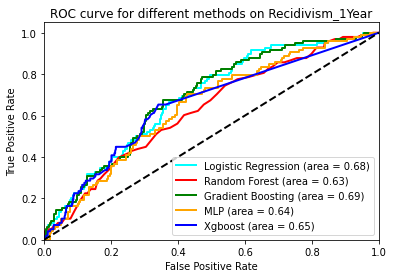

In [68]:
from sklearn.linear_model import LinearRegression,LogisticRegression


X_train1,X_test1,y_train1,y_test1=train_test_split(raw_extend[raw_extend['Gender']==0].drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_extend[raw_extend['Gender']==0]['Recidivism_Arrest_Year1'])
fpr_list,tpr_list,auc_list=dict(),dict(),dict()


logistic=LogisticRegression(max_iter=1000)
logistic.fit(X_train1.fillna(0),y_train1)
fpr_list[0], tpr_list[0], _ = roc_curve(y_test1, y_roc(logistic,X_test1.fillna(0)))
print('Logistic regression train score:',
      logistic.score(X_train1.fillna(0),y_train1),'\n test score:',logistic.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Logistic regression train Brier score:',
      brier_score(logistic.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(logistic.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(logistic,X_test1.fillna(0))))

RF=RandomForestClassifier(n_estimators=150,min_samples_split=2)
RF.fit(X_train1.fillna(0),y_train1)
fpr_list[1], tpr_list[1], _ = roc_curve(y_test1, y_roc(RF,X_test1.fillna(0)))
print('Random forest train score:',
      RF.score(X_train1.fillna(0),y_train1),'\n test score:',RF.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Random forest  train Brier score:',
      brier_score(RF.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(RF.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(RF,X_test1.fillna(0))))

GBDT=GradientBoostingClassifier()
params_SGD={'n_estimators':[150],'min_samples_split':[2,4]}
grid_SGD=GridSearchCV(GBDT,param_grid=params_SGD,cv=3)
grid_SGD.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[2], tpr_list[2], _ = roc_curve(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0)))
print('SGD best layer size:',grid_SGD.best_params_,'\n best train score:',
      grid_SGD.best_score_,'\n test score:',grid_SGD.score(X_test1.fillna(0),y_test1.fillna(0)),'\n SGD  train Brier score:',
      brier_score(grid_SGD.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_SGD.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0))))

pipe = Sequential()
n_cols = X_train1.shape[1]
pipe.add(BatchNormalization(input_shape=(n_cols,)))
pipe.add(Dense(70, activation= 'linear'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(100, activation='linear'))
pipe.add(BatchNormalization())
pipe.add(Dense(2, activation='softmax'))
    #model.compile(
        #optimizer='Adam',
        #loss='mean_squared_error',
        #metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=50)
sgd = keras.optimizers.SGD(lr=.001, decay=2e-4, momentum=0.9, nesterov=True)
pipe.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'sgd', metrics=['accuracy'])
history=pipe.fit(X_train1.fillna(0).astype('float32'), y_train1, validation_split=0.3, epochs=200, callbacks=[early_stopping_monitor])
#history=model.fit(X_train, y_train, validation_split=0.2, epochs=25)
score = pipe.evaluate(X_test1.fillna(0).astype('float32'), y_test1, verbose=0)
pipe.fit(X_train1.fillna(0).astype('float32'),y_train1.fillna(0))
fpr_list[3], tpr_list[3], _ = roc_curve(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32')))
print('MLP train Brier score:',
      brier_score(pipe.predict_proba(X_train1.fillna(0).astype('float32')),y_train1),'\n test Brier score:',brier_score(pipe.predict_proba(X_test1.fillna(0).astype('float32')),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32'))))


XGB=XGBClassifier()
params_XGB={'n_estimators':[100,200],'max_depth':[8,10],'reg_alpha':[0.001],'reg_lambda':[10000,1000,500]}
grid_XGB=GridSearchCV(XGB,param_grid=params_XGB,cv=3)
grid_XGB.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[4], tpr_list[4], _ = roc_curve(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0)))
print('Xgboost best layer size:',grid_XGB.best_params_,'\n best train score:',
      grid_XGB.best_score_,'\n test score:',grid_XGB.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Xgboost train Brier score:',
      brier_score(grid_XGB.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_XGB.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0))))



colors = cycle(['aqua', 'red', 'green','orange','blue'])
labels=['Logistic Regression','Random Forest','Gradient Boosting','MLP','Xgboost']
for i, label, color in zip(range(len(fpr_list)), labels, colors):
    legend= label + ' (area = {1:0.2f})'''.format(i, auc(fpr_list[i], tpr_list[i]))
    plt.plot(fpr_list[i], tpr_list[i], color=color, lw=2,label=legend)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for different methods on Recidivism_1Year')
plt.legend(loc="lower right")
plt.savefig('ROC_plot.png',dpi=300)
plt.show()

Logistic regression train score: 0.7071175577669084 
 test score: 0.6976979509233494 
 Logistic regression train Brier score: 0.1911511398195571 
 test Brier score: 0.19624342201348394 
 AUROC: 0.6807684459972221
Random forest train score: 1.0 
 test score: 0.6971920060713382 
 Random forest  train Brier score: 0.027696868499466558 
 test Brier score: 0.20025378193776927 
 AUROC: 0.6584534309865071
SGD best layer size: {'min_samples_split': 4, 'n_estimators': 150} 
 best train score: 0.6971667856422273 
 test score: 0.6984568682013661 
 SGD  train Brier score: 0.1767656235270351 
 test Brier score: 0.1951431776816539 
 AUROC: 0.6851114706682513


C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
260/260 [==============================] - 1s 2ms/step - loss: 0.7883 - accuracy: 0.5839 - val_loss: 0.6122 - val_accuracy: 0.6889
Epoch 2/200
260/260 [==============================] - 0s 1ms/step - loss: 0.6624 - accuracy: 0.6470 - val_loss: 0.6046 - val_accuracy: 0.6903
Epoch 3/200
260/260 [==============================] - 0s 1ms/step - loss: 0.6303 - accuracy: 0.6767 - val_loss: 0.6050 - val_accuracy: 0.6906
Epoch 4/200
260/260 [==============================] - 0s 1ms/step - loss: 0.6208 - accuracy: 0.6796 - val_loss: 0.6028 - val_accuracy: 0.6897
Epoch 5/200
260/260 [==============================] - 0s 1ms/step - loss: 0.6158 - accuracy: 0.6828 - val_loss: 0.5998 - val_accuracy: 0.6897
Epoch 6/200
260/260 [==============================] - 0s 1ms/step - loss: 0.6103 - accuracy: 0.6863 - val_loss: 0.5994 - val_accuracy: 0.6897
Epoch 7/200
260/260 [==============================] - 0s 1ms/step - loss: 0.6061 - accuracy: 0.6857 - val_loss: 0.5946 - val_accuracy: 0.6914

Epoch 58/200
260/260 [==============================] - 0s 1ms/step - loss: 0.5762 - accuracy: 0.6966 - val_loss: 0.5693 - val_accuracy: 0.7040
Epoch 59/200
260/260 [==============================] - 0s 1ms/step - loss: 0.5720 - accuracy: 0.6982 - val_loss: 0.5690 - val_accuracy: 0.7057
Epoch 60/200
260/260 [==============================] - 0s 1ms/step - loss: 0.5749 - accuracy: 0.6958 - val_loss: 0.5697 - val_accuracy: 0.7057
Epoch 61/200
260/260 [==============================] - 0s 1ms/step - loss: 0.5767 - accuracy: 0.6947 - val_loss: 0.5707 - val_accuracy: 0.7046
Epoch 62/200
260/260 [==============================] - 0s 1ms/step - loss: 0.5752 - accuracy: 0.6971 - val_loss: 0.5696 - val_accuracy: 0.7032
Epoch 63/200
260/260 [==============================] - 0s 1ms/step - loss: 0.5770 - accuracy: 0.6976 - val_loss: 0.5708 - val_accuracy: 0.7057
Epoch 64/200
260/260 [==============================] - 0s 1ms/step - loss: 0.5736 - accuracy: 0.6980 - val_loss: 0.5681 - val_accuracy:

Epoch 115/200
260/260 [==============================] - 0s 1ms/step - loss: 0.5703 - accuracy: 0.7000 - val_loss: 0.5662 - val_accuracy: 0.7085
Epoch 116/200
260/260 [==============================] - 0s 1ms/step - loss: 0.5731 - accuracy: 0.6966 - val_loss: 0.5685 - val_accuracy: 0.7046
Epoch 117/200
260/260 [==============================] - 0s 1ms/step - loss: 0.5714 - accuracy: 0.6971 - val_loss: 0.5669 - val_accuracy: 0.7057
Epoch 118/200
260/260 [==============================] - 0s 1ms/step - loss: 0.5727 - accuracy: 0.6957 - val_loss: 0.5679 - val_accuracy: 0.7057
Epoch 119/200
260/260 [==============================] - 0s 1ms/step - loss: 0.5705 - accuracy: 0.6961 - val_loss: 0.5697 - val_accuracy: 0.7055
Epoch 120/200
260/260 [==============================] - 0s 1ms/step - loss: 0.5721 - accuracy: 0.6983 - val_loss: 0.5676 - val_accuracy: 0.7071
Epoch 121/200
260/260 [==============================] - 0s 1ms/step - loss: 0.5706 - accuracy: 0.6978 - val_loss: 0.5691 - val_ac

C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:4

MLP train Brier score: 0.18977180160723062 
 test Brier score: 0.19587808978363402 
 AUROC: 0.6817445004462644
Xgboost best layer size: {'max_depth': 10, 'n_estimators': 100, 'reg_alpha': 0.001, 'reg_lambda': 1000} 
 best train score: 0.7039127810136172 
 test score: 0.7030103718694662 
 Xgboost train Brier score: 0.16887619509860682 
 test Brier score: 0.19520220967475316 
 AUROC: 0.6859977352673052


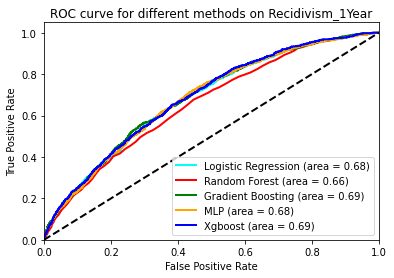

In [69]:
from sklearn.linear_model import LinearRegression,LogisticRegression


X_train1,X_test1,y_train1,y_test1=train_test_split(raw_extend[raw_extend['Gender']==1].drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_extend[raw_extend['Gender']==1]['Recidivism_Arrest_Year1'])
fpr_list,tpr_list,auc_list=dict(),dict(),dict()


logistic=LogisticRegression(max_iter=1000)
logistic.fit(X_train1.fillna(0),y_train1)
fpr_list[0], tpr_list[0], _ = roc_curve(y_test1, y_roc(logistic,X_test1.fillna(0)))
print('Logistic regression train score:',
      logistic.score(X_train1.fillna(0),y_train1),'\n test score:',logistic.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Logistic regression train Brier score:',
      brier_score(logistic.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(logistic.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(logistic,X_test1.fillna(0))))

RF=RandomForestClassifier(n_estimators=150,min_samples_split=2)
RF.fit(X_train1.fillna(0),y_train1)
fpr_list[1], tpr_list[1], _ = roc_curve(y_test1, y_roc(RF,X_test1.fillna(0)))
print('Random forest train score:',
      RF.score(X_train1.fillna(0),y_train1),'\n test score:',RF.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Random forest  train Brier score:',
      brier_score(RF.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(RF.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(RF,X_test1.fillna(0))))

GBDT=GradientBoostingClassifier()
params_SGD={'n_estimators':[150],'min_samples_split':[2,4]}
grid_SGD=GridSearchCV(GBDT,param_grid=params_SGD,cv=3)
grid_SGD.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[2], tpr_list[2], _ = roc_curve(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0)))
print('SGD best layer size:',grid_SGD.best_params_,'\n best train score:',
      grid_SGD.best_score_,'\n test score:',grid_SGD.score(X_test1.fillna(0),y_test1.fillna(0)),'\n SGD  train Brier score:',
      brier_score(grid_SGD.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_SGD.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0))))

pipe = Sequential()
n_cols = X_train1.shape[1]
pipe.add(BatchNormalization(input_shape=(n_cols,)))
pipe.add(Dense(70, activation= 'linear'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(100, activation='linear'))
pipe.add(BatchNormalization())
pipe.add(Dense(2, activation='softmax'))
    #model.compile(
        #optimizer='Adam',
        #loss='mean_squared_error',
        #metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=50)
sgd = keras.optimizers.SGD(lr=.001, decay=2e-4, momentum=0.9, nesterov=True)
pipe.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'sgd', metrics=['accuracy'])
history=pipe.fit(X_train1.fillna(0).astype('float32'), y_train1, validation_split=0.3, epochs=200, callbacks=[early_stopping_monitor])
#history=model.fit(X_train, y_train, validation_split=0.2, epochs=25)
score = pipe.evaluate(X_test1.fillna(0).astype('float32'), y_test1, verbose=0)
pipe.fit(X_train1.fillna(0).astype('float32'),y_train1.fillna(0))
fpr_list[3], tpr_list[3], _ = roc_curve(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32')))
print('MLP train Brier score:',
      brier_score(pipe.predict_proba(X_train1.fillna(0).astype('float32')),y_train1),'\n test Brier score:',brier_score(pipe.predict_proba(X_test1.fillna(0).astype('float32')),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32'))))


XGB=XGBClassifier()
params_XGB={'n_estimators':[100,200],'max_depth':[8,10],'reg_alpha':[0.001],'reg_lambda':[10000,1000,500]}
grid_XGB=GridSearchCV(XGB,param_grid=params_XGB,cv=3)
grid_XGB.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[4], tpr_list[4], _ = roc_curve(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0)))
print('Xgboost best layer size:',grid_XGB.best_params_,'\n best train score:',
      grid_XGB.best_score_,'\n test score:',grid_XGB.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Xgboost train Brier score:',
      brier_score(grid_XGB.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_XGB.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0))))



colors = cycle(['aqua', 'red', 'green','orange','blue'])
labels=['Logistic Regression','Random Forest','Gradient Boosting','MLP','Xgboost']
for i, label, color in zip(range(len(fpr_list)), labels, colors):
    legend= label + ' (area = {1:0.2f})'''.format(i, auc(fpr_list[i], tpr_list[i]))
    plt.plot(fpr_list[i], tpr_list[i], color=color, lw=2,label=legend)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for different methods on Recidivism_1Year')
plt.legend(loc="lower right")
plt.savefig('ROC_plot.png',dpi=300)
plt.show()

In [71]:
raw_extend[raw_extend['Gender']==1]

,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,FSMXSP,FSTOVP,FTAXP,FTELP,FTENP,FTOILP,FVACSP,FVALP,FVEHP,FWATP
0,-1.733539,1,0,1.100330,15,0,-1.286229,2,0,1.258442,...,-0.654887,0.481108,0.457411,3.631924,-1.068371,-0.302085,-1.402483,0.231283,-0.668677,-0.620890
1,-1.733409,1,0,0.039825,15,0,-0.027176,1,2,-0.389139,...,-0.654887,0.481108,0.457411,3.631924,-1.068371,-0.302085,-1.402483,0.231283,-0.668677,-0.620890
2,-1.733150,1,1,0.570077,15,0,0.392508,0,2,-0.389139,...,-0.654887,0.481108,0.457411,3.631924,-1.068371,-0.302085,-1.402483,0.231283,-0.668677,-0.620890
3,-1.733021,1,1,0.039825,15,0,-0.866544,1,2,1.258442,...,-0.654887,0.481108,0.457411,3.631924,-1.068371,-0.302085,-1.402483,0.231283,-0.668677,-0.620890
4,-1.732373,1,0,1.100330,15,0,-0.446860,2,1,1.258442,...,-0.654887,0.481108,0.457411,3.631924,-1.068371,-0.302085,-1.402483,0.231283,-0.668677,-0.620890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18023,1.718110,1,0,-1.020680,6,0,0.812193,0,1,-0.389139,...,-0.780227,0.805995,-0.148737,-0.195273,-0.945059,1.380755,2.569246,0.621093,-1.121273,-0.501324
18024,1.721218,1,1,-0.490428,6,0,-0.446860,2,0,1.258442,...,-0.780227,0.805995,-0.148737,-0.195273,-0.945059,1.380755,2.569246,0.621093,-1.121273,-0.501324
18025,1.727305,1,1,0.570077,6,0,-2.125597,2,1,0.434651,...,-0.780227,0.805995,-0.148737,-0.195273,-0.945059,1.380755,2.569246,0.621093,-1.121273,-0.501324
18026,1.728341,1,1,1.100330,6,0,-1.286229,2,1,0.434651,...,-0.780227,0.805995,-0.148737,-0.195273,-0.945059,1.380755,2.569246,0.621093,-1.121273,-0.501324


In [84]:
brier_score(logistic.predict_proba(X_train1[X_train1['Gender']==0].fillna(0)),y_train1[X_train1['Gender']==0])

0.14789770544363473